# Using Kaggle to download the dataset

In [ ]:
from google.colab import files
import kagglehub
    
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
path = kagglehub.dataset_download("eeshawn/flickr30k")
print(path)

Using Colab cache for faster access to the 'flickr30k' dataset.
/kaggle/input/flickr30k


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Declaring Addresses


## Delaring Addresses

In [4]:
import os, shutil, glob

drive_base = "/content/drive/MyDrive/captioneer"
drive_scripts = os.path.join(drive_base, "scripts")
drive_captions = os.path.join(drive_base, "processed_captions")

colab_scripts = "/content/scripts"
colab_captions = "/content/processed_captions"
colab_images = os.path.join(path, "flickr30k_images")

os.makedirs(colab_scripts, exist_ok=True)
os.makedirs("/content/models", exist_ok=True)

## Copying Scripts

In [5]:
for fname in ["dataset_transformer.py", "model_transformer.py", 'train_transformer.py']:
    src = os.path.join(drive_scripts, fname)
    dst = os.path.join(colab_scripts, fname)
    if os.path.exists(dst):
        os.remove(dst)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied", fname, "to", dst)
    else:
        print("not found in drive:", src)
print("Scripts placed in", colab_scripts)

Copied dataset_transformer.py to /content/scripts/dataset_transformer.py
Copied model_transformer.py to /content/scripts/model_transformer.py
Copied train_transformer.py to /content/scripts/train_transformer.py
Scripts placed in /content/scripts


## Copying `processed_captions`

In [ ]:
import glob

# copy captions folder
if os.path.exists(colab_captions):
    print("Removing existing", colab_captions)
    shutil.rmtree(colab_captions)
shutil.copytree(drive_captions, colab_captions)
print("Copied processed captions to", colab_captions)

# quick checks
images = glob.glob(os.path.join(colab_images, "*.jpg"))
print("Number of images:", len(images))
json_files = glob.glob(os.path.join(colab_captions, "*.json"))
print("Processed captions files:", json_files)

# Training

## Dataloader Creation

In [ ]:
# Dataloader creation (uses dataset_attention.py)
import sys
sys.path.append('/content/scripts')
from importlib import reload
import dataset_transformer
reload(dataset_transformer)

from torch.utils.data import DataLoader

train_seq = os.path.join(colab_captions, "sequences_train.json")
val_seq = os.path.join(colab_captions, "sequences_val.json")
vocab_path = os.path.join(colab_captions, "vocab_word2idx.json")

# dataset + loader (small batch for checking)
batch_size = 8
ds = dataset_transformer.CaptionImageDataset(train_seq, colab_images, vocab_json=vocab_path, image_size=224)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=dataset_transformer.collate_fn, num_workers=2)

# inspect one batch
images, seqs, names = next(iter(loader))
print("Images shape:", images.shape)
print("Seqs shape:", seqs.shape)
print("Sample image names:", names[:4])

## Importing and Preparation
double checking libraries and paths and scripts

In [ ]:
# Cell 14: Importing and Preparation

import os, sys, json, torch
from importlib import reload
import model_transformer, train_transformer
reload(model_transformer)
reload(train_transformer)

# paths
colab_captions = "/content/processed_captions"
colab_images = os.path.join(path, "flickr30k_images")
vocab_path = os.path.join(colab_captions, "vocab_word2idx.json")
idx2word_path = os.path.join(colab_captions, "vocab_idx2word.json")
train_seq = os.path.join(colab_captions, "sequences_train.json")
val_seq = os.path.join(colab_captions, "sequences_val.json")
test_seq = os.path.join(colab_captions, "sequences_test.json")
models_dir = "/content/models"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load vocab jsons
with open(vocab_path, "r", encoding="utf-8") as f:
    word2idx = json.load(f)
with open(idx2word_path, "r", encoding="utf-8") as f:
    raw_idx2 = json.load(f)
idx2word = {int(k): v for k, v in raw_idx2.items()}

true_vocab_size = max(word2idx.values()) + 1
print(f"Dictionary length is {len(word2idx)}, but max index is {max(word2idx.values())}.")

start_token = word2idx.get("<START>", 2)
end_token = word2idx.get("<END>", 3)
pad_token = word2idx.get("<PAD>", 0)

## Sanity Check

In [ ]:
embed_dim = 768
n_heads = 4
decoder_layers = 3
dim_feedforward = 1024
dropout = 0.1

enc = model_transformer.EncoderCNN(feat_embed_dim=embed_dim).to(device)
dec = model_transformer.DecoderWithTransformer(
    vocab_size=len(word2idx),
    embed_dim=embed_dim,
    n_heads=n_heads,
    decoder_layers=decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    device=device,
    word2idx=word2idx
).to(device)

# single-batch forward pass
images, seqs, names = next(iter(loader))
images = images.to(device)
seqs = seqs.to(device)

enc.train(); dec.train()
feats = enc(images)
print("Encoder feats shape:", feats.shape)
logits = dec(feats, seqs[:, :-1])
print("Decoder logits shape:", logits.shape)
print("Target sequence shape:", seqs[:, 1:].shape)

# simple loss step
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token)
B, L, V = logits.shape
loss = criterion(logits.reshape(B*L, V), seqs[:,1:].reshape(-1))
print("One-step train loss:", loss.item())

In [ ]:
reload(train_transformer)

config = {
    'train_sequences': train_seq,
    'val_sequences': val_seq,
    'images_dir': colab_images,
    'vocab_path': vocab_path,
    'save_dir': models_dir,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 64,
    'epochs': 20,
    'lr': 1e-4,
    'patience': 5,
    'max_len': 30,
    'embed_dim': 768,
    'n_heads': 4,
    'decoder_layers': 3,
    'dim_feedforward': 1024,
    'dropout': 0.1,
    'beam_width': 3,
    'resume_path': '/content/models/best_model_epoch8_bleu0.2239.pt'
}

history = train_transformer.train_loop(config)

## Visualizing Losses & Scores

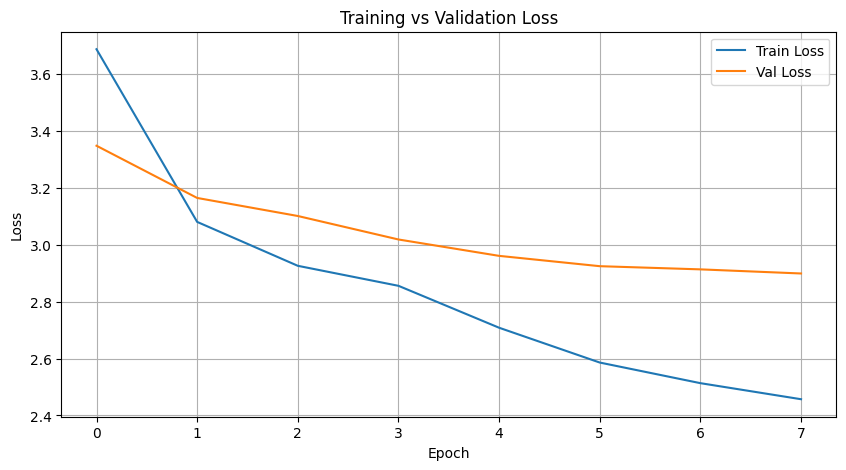

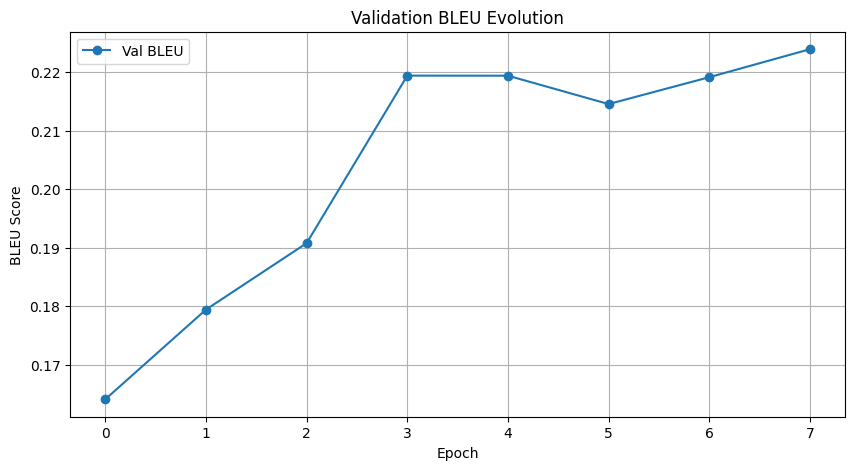

In [13]:
import matplotlib.pyplot as plt

checkpoint = torch.load('/content/models/best_model_epoch8_bleu0.2239.pt', map_location=device)
history = checkpoint['history']

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot BLEU scores
plt.figure(figsize=(10,5))
plt.plot(history["val_bleu"], marker="o", label="Val BLEU")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("Validation BLEU Evolution")
plt.legend()
plt.grid(True)
plt.show()

## Load Best Model And Check Generated Captions VS Ground Truth

Loading best model: /content/models/best_model_epoch8_bleu0.2239.pt
Loading DistilBERT model to extract word embeddings...
Initializing embedding layer for vocabulary of size 4998...
Custom embedding layer created and initialized with DistilBERT weights.


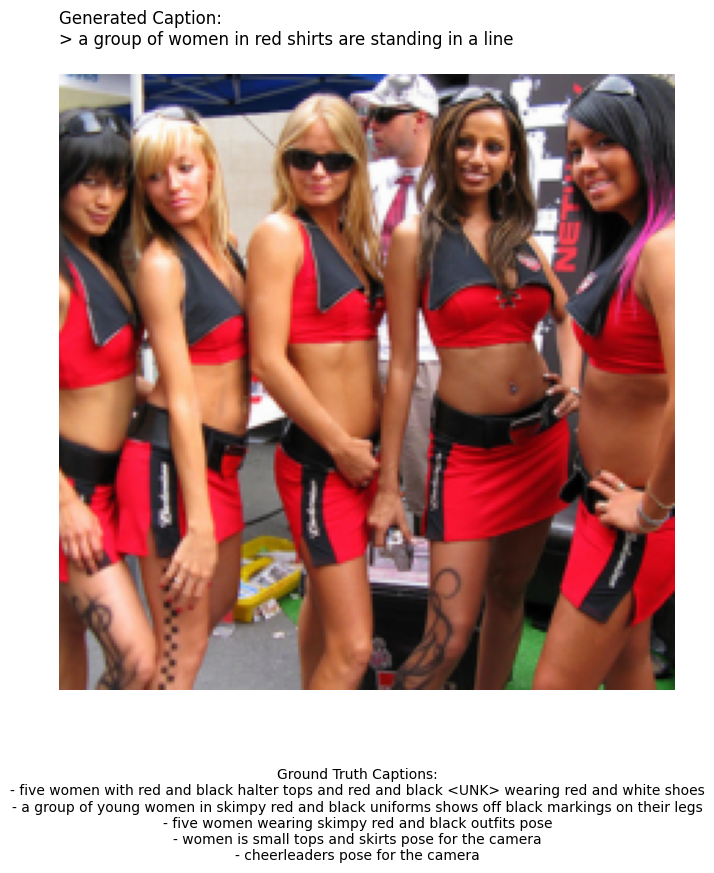

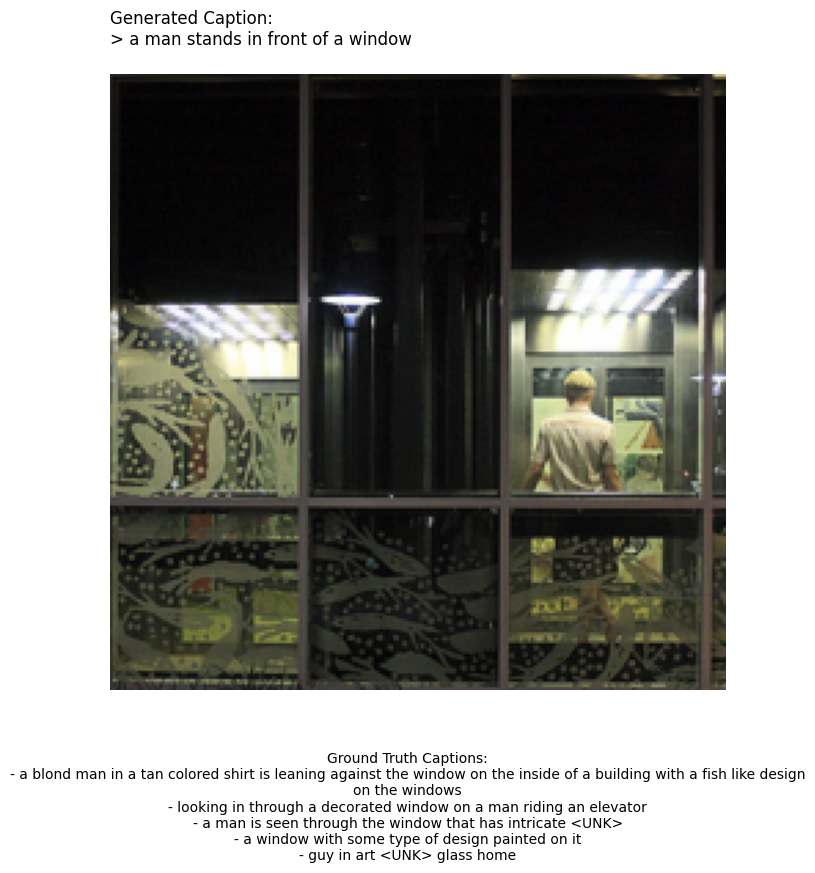

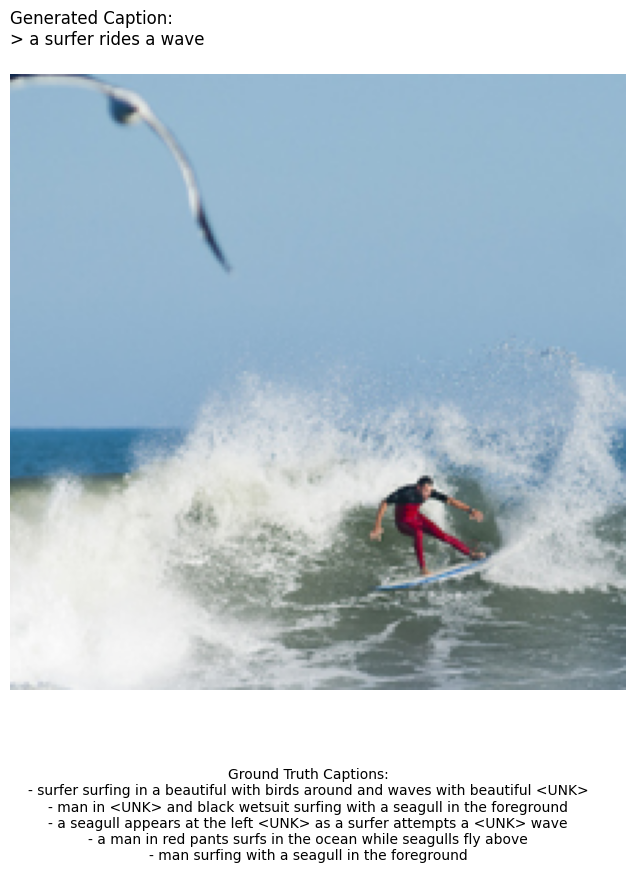

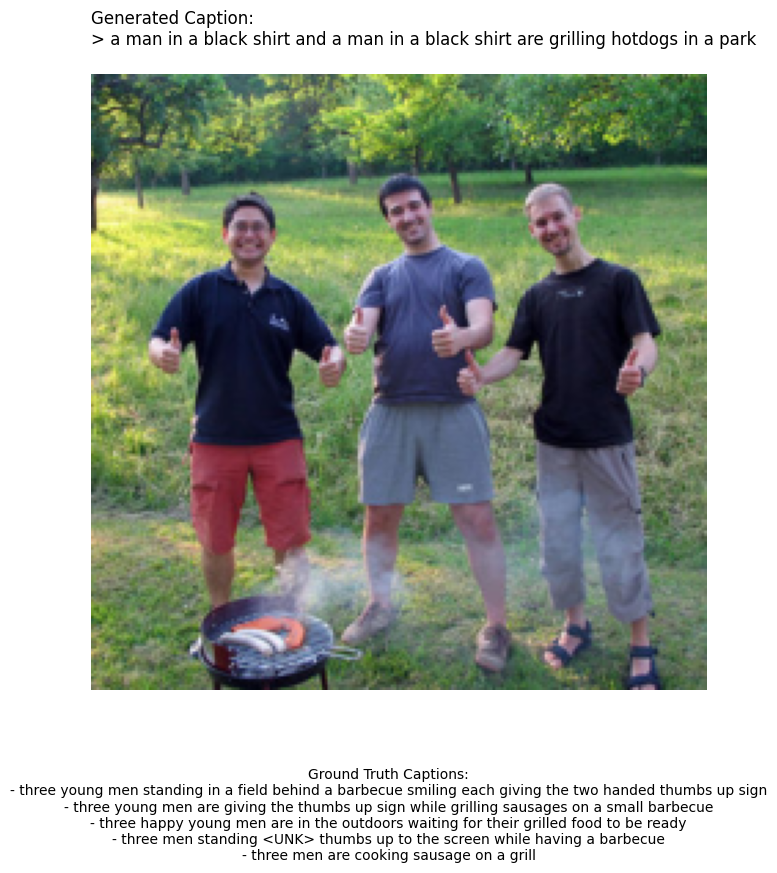

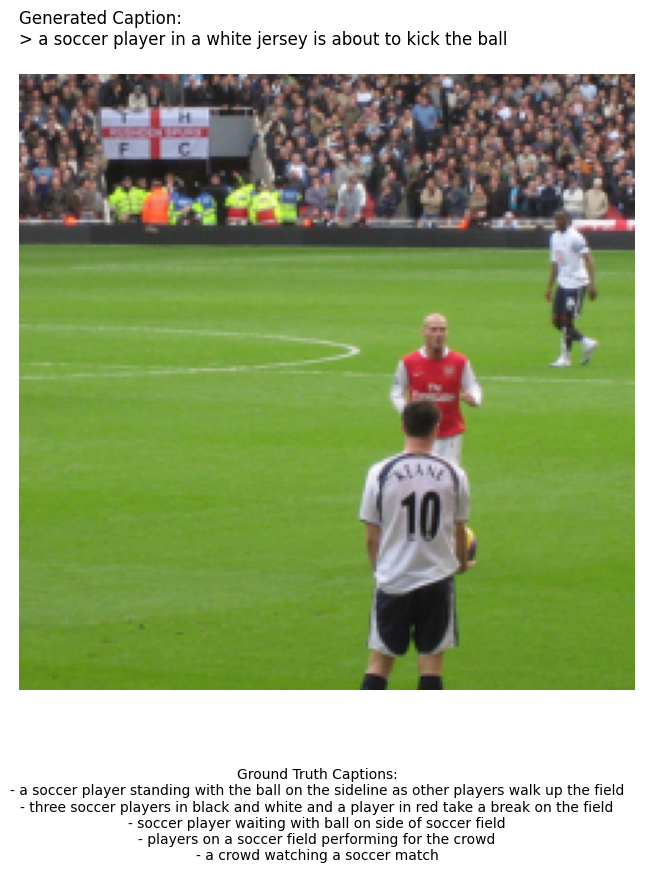

In [22]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt

reload(model_transformer)

best_model_path = '/content/models/best_model_epoch8_bleu0.2239.pt'
print(f"Loading best model: {best_model_path}")

# Initialize models with the config used for training
encoder = model_transformer.EncoderCNN(
    feat_embed_dim=config['embed_dim']
).to(device)
decoder = model_transformer.DecoderWithTransformer(
    vocab_size=len(word2idx),
    embed_dim=config['embed_dim'],
    n_heads=config['n_heads'],
    decoder_layers=config['decoder_layers'],
    dim_feedforward=config['dim_feedforward'],
    dropout=config['dropout'],
    device=device,
    word2idx=word2idx
).to(device)

# Load state dictionaries
checkpoint = torch.load(best_model_path, map_location=device)
encoder.load_state_dict(checkpoint['encoder_state'])
decoder.load_state_dict(checkpoint['decoder_state'])
encoder.eval()
decoder.eval()

test_ds = dataset_transformer.CaptionImageDataset(
    test_seq, colab_images, vocab_path, is_val=True
)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=True, collate_fn=dataset_transformer.collate_fn
)

def sequence_to_text(seq, idx2word_map):
    return ' '.join([idx2word_map.get(idx, "<UNK>") for idx in seq if idx not in {start_token, end_token, pad_token}])

# Generate and display captions
num_samples_to_show = 5
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

with torch.no_grad():
    for i, (image_t, caps_t_list, img_name) in enumerate(test_loader):
        if i >= num_samples_to_show:
            break

        image_t = image_t.to(device)

        # Generate caption
        feats = encoder(image_t)
        prediction_idx = decoder.beam_search_decode(
            feats,
            start_token,
            end_token,
            beam_width = 3
        )[0]
        predicted_caption = sequence_to_text(prediction_idx, idx2word)

        # Prepare ground truth captions
        gt_captions = [sequence_to_text(cap.squeeze().tolist(), idx2word) for cap in caps_t_list[0]]

        # Display the image and captions
        img_display = image_t.squeeze(0).cpu().numpy().transpose((1, 2, 0))
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f"Generated Caption:\n> {predicted_caption}\n", loc='left')

        gt_text = "Ground Truth Captions:\n" + "\n".join([f"- {cap}" for cap in gt_captions])
        plt.figtext(0.5, -0.1, gt_text, ha="center", fontsize=10, wrap=True)
        plt.show()